# Data Cleaning and Preprocessing
## Dataset: WEB-IDS23 Dataset
#### Tasks: 
1. Visualize and understand the data
2. Identify the best algorithm 

#### Navigation:
1. [Import Libraries](#import-libraries)
2. [Utility Functions](#utility-functions)
3. [Load the dataset](#load-the-dataset)
4. [Preprocess the dataset](#preprocess-the-dataset)
5. [Distribution of all the features](#distribution-of-all-the-features)
6. [Distribution after MinMaxScaler Normalisation](#distribution-after-minmaxscaler-normalisation)
7. [Train and Evaluate the Model](#train-and-evaluate-the-model)
8. [Dimentionality reduced data for model training](#dimentionality-reduced-data-for-model-training)
9. [Boosting Classifiers Training](#boosting-classifiers-training)
10. [K - Nearest Neighbour](#k-nearest-neighbour)
11. [Performance Comparison](#performance-comparison)

        Author: Nithusikan T.
        Email: e19266@eng.pdn.ac.lk
        Date: 25/05/2025

#### Import Libraries  [🏠](#data-cleaning-and-preprocessing) <a id="import-libraries"></a>

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score


c:\Accadamics\Software tools\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Utility Functions [🏠](#data-cleaning-and-preprocessing) <a id="utility-functions"></a>

In [ ]:
def load_all_csv_files(folder_path):
    """
    Loads all rows from each CSV file in the folder, preserving the full
    distribution of data across files.

    Skips specific small or irrelevant files.

    Parameters:
        folder_path (str): Path to the folder containing CSV files.

    Returns:
        pd.DataFrame: Combined DataFrame with all data.
    """
    ignore_files = {
        "web-ids23_smtp_enum.csv", 
        "ssh_login.csv", 
        "ssh_login_successful.csv"
    }

    all_dfs = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and filename not in ignore_files:
            file_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(file_path)
                all_dfs.append(df)
                print(f"{filename}: loaded {df.shape[0]} rows.")
            except Exception as e:
                print(f"Could not read {filename}: {e}")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

def preprocess_data(df, columns_2_drop, target_columns=['attack_type', 'attack']):
    """
    Preprocess the DataFrame by handling missing values, encoding categorical variables,
    and scaling numerical features.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    target_column (str): Name of the target variable column.
    columns_2_drop (list): List of columns to drop from the DataFrame.

    Returns:
    X (pd.DataFrame): Features DataFrame.
    y_1 (pd.Series): Target variable Series.
    y_2 (pd.Series): Second target variable Series.
    """
    # Handle missing values
    df = df.dropna(axis=0, how='any')  # Drop rows with any missing values

    # Separate features and target variable
    y_1 = df[target_columns[0]]  # attack_type
    y_2 = df[target_columns[1]]  # attack
    X = df.drop(columns=target_columns)

    # Drop some columns that are not needed for analysis
    print(f"Dropping columns: {columns_2_drop}") # df.columns[0:4])
    X = X.drop(columns=columns_2_drop)

    # Encode categorical variables if any
    X = pd.get_dummies(X, drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return pd.DataFrame(X_scaled, columns=X.columns), pd.Series(y_1), pd.Series(y_2)

def visualize_covariance_matrix(X, color="Blues"):
    """
    Visualize the covariance matrix of the features in the DataFrame.

    Parameters:
    X (pd.DataFrame): Features DataFrame.
    color (str): Color map for the heatmap.

    Returns:
    None
    """
    # plt.figure(figsize=(15, 15))
    covariance_matrix = X.cov()
    # sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap=color)
    # plt.title("Covariance Matrix")
    # # plt.show()

    return covariance_matrix


def train_and_evaluate_model(X, y, color="Blues",top_features=None, classifiers=None):
    """
    Train and evaluate multiple classifiers on the given dataset.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    top_features (list, optional): List of top features to select. If None, all features are used.

    Returns:
    None
    """

    # Select top features if provided
    if top_features is None:
        top_features = X.columns.tolist()  # Use all features if no specific ones are provided
    X_selected = X[top_features]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    trained_clfs = {}
    performance_dict = {}

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        classifiers[name] = clf
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Store the perormance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        performance_dict[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }

        # Print classification report
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                    xticklabels=clf.classes_, yticklabels=clf.classes_)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return trained_clfs, performance_dict

def visualize_feature_importances(X, classifier):
    """
    Visualize feature importances for a given classifier.
    Parameters:
    X (pd.DataFrame): Features.
    classifier: The trained classifier with feature importances.
    Returns:
    None
    """
    # Visualize the feature importances for Random Forest
    plt.figure(figsize=(12, 8))
    importances = classifier.feature_importances_
    indices = importances.argsort()[::-1]
    plt.title(f"Feature Importances - {classifier.__class__.__name__}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

def print_low_performance_classes(report, threshold=0.7):
    """
    Print classes with precision, recall, and f1-score below a specified threshold.

    Parameters:
    report (dict): Classification report from sklearn.
    threshold (float): Threshold for filtering classes.

    Returns:
    None
    """
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
            f1_score = metrics.get('f1-score', 0)
            if precision < threshold or recall < threshold or f1_score < threshold:
                print(f"Class: {class_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

def plot_feature_distribution_grid(df, features, cols=3, color="blue"):
    """
    Plot the distribution of multiple features in a grid layout.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of feature names to plot.
    cols (int): Number of plots per row.
    color (str): Color for the plots.
    
    Returns:
    None
    """
    num_features = len(features)
    rows = (num_features + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of multi-row layout

    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=True, color=color, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


### Load the dataset[🏠](#data-cleaning-and-preprocessing) <a id="load-the-dataset"></a>

In [ ]:
df = load_all_csv_files("E:\\Accadamics\\Semesters\\Final Year Project\\Data\\web-ids23")

web-ids23_benign.csv loaded with 5000 rows and 38 columns.
web-ids23_bruteforce_http.csv loaded with 5000 rows and 38 columns.
web-ids23_bruteforce_https.csv loaded with 5000 rows and 38 columns.
web-ids23_dos_http.csv loaded with 5000 rows and 38 columns.
web-ids23_dos_https.csv loaded with 5000 rows and 38 columns.
web-ids23_ftp_login.csv loaded with 5000 rows and 38 columns.
web-ids23_ftp_version.csv loaded with 5000 rows and 38 columns.
web-ids23_hostsweep_Pn.csv loaded with 5000 rows and 38 columns.
web-ids23_hostsweep_sn.csv loaded with 5000 rows and 38 columns.
web-ids23_portscan.csv loaded with 5000 rows and 38 columns.
web-ids23_revshell_http.csv loaded with 5000 rows and 38 columns.
web-ids23_revshell_https.csv loaded with 5000 rows and 38 columns.
web-ids23_smtp_version.csv loaded with 5000 rows and 38 columns.
web-ids23_sql_injection_http.csv loaded with 5000 rows and 38 columns.
web-ids23_sql_injection_https.csv loaded with 5000 rows and 38 columns.
web-ids23_ssh_login.csv

### Preprocess the dataset [🏠](#data-cleaning-and-preprocessing) <a id="preprocess-the-dataset"></a>

In [ ]:
# Drop columns that are not needed for analysis
columns_2_drop = [
    'uid',               # Unique flow ID (not predictive)
    'ts',                # Timestamp (not useful directly; time-series analysis might use it differently)
    'id.orig_h',         # Origin IP — environment-specific
    'id.resp_h',         # Destination IP — environment-specific
    'service',           # Tool-specific, may not generalize
    'traffic_direction', # Typically derived from IPs — not generalizable
]

target_columns = ['attack_type', 'attack']  # Define target columns
X, y_attack_type, y_attack = preprocess_data(df, columns_2_drop=columns_2_drop, target_columns=target_columns)

Dropping columns: ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'traffic_direction']


In [9]:
# Visualize covariance matrix
cov_matrix = visualize_covariance_matrix(X, color="Reds")
print("Covariance matrix:\n", cov_matrix)

Covariance matrix:
                           flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
flow_duration                  1.000013      0.347264      0.329272   
fwd_pkts_tot                   0.347264      1.000013      0.982939   
bwd_pkts_tot                   0.329272      0.982939      1.000013   
fwd_data_pkts_tot              0.295709      0.891859      0.882558   
bwd_data_pkts_tot              0.300802      0.971768      0.988624   
fwd_pkts_per_sec              -0.083550     -0.150718     -0.136358   
bwd_pkts_per_sec              -0.079426     -0.143044     -0.127633   
flow_pkts_per_sec             -0.081675     -0.147221     -0.132319   
down_up_ratio                  0.130519      0.262941      0.311444   
fwd_header_size_tot            0.348512      0.999917      0.982900   
fwd_header_size_min            0.033424     -0.024917     -0.026904   
fwd_header_size_max            0.074895      0.155943      0.135427   
bwd_header_size_tot            0.327548      0.982973    

### Distribution of all the features [🏠](#data-cleaning-and-preprocessing) <a id="distribution-of-all-the-features"></a>

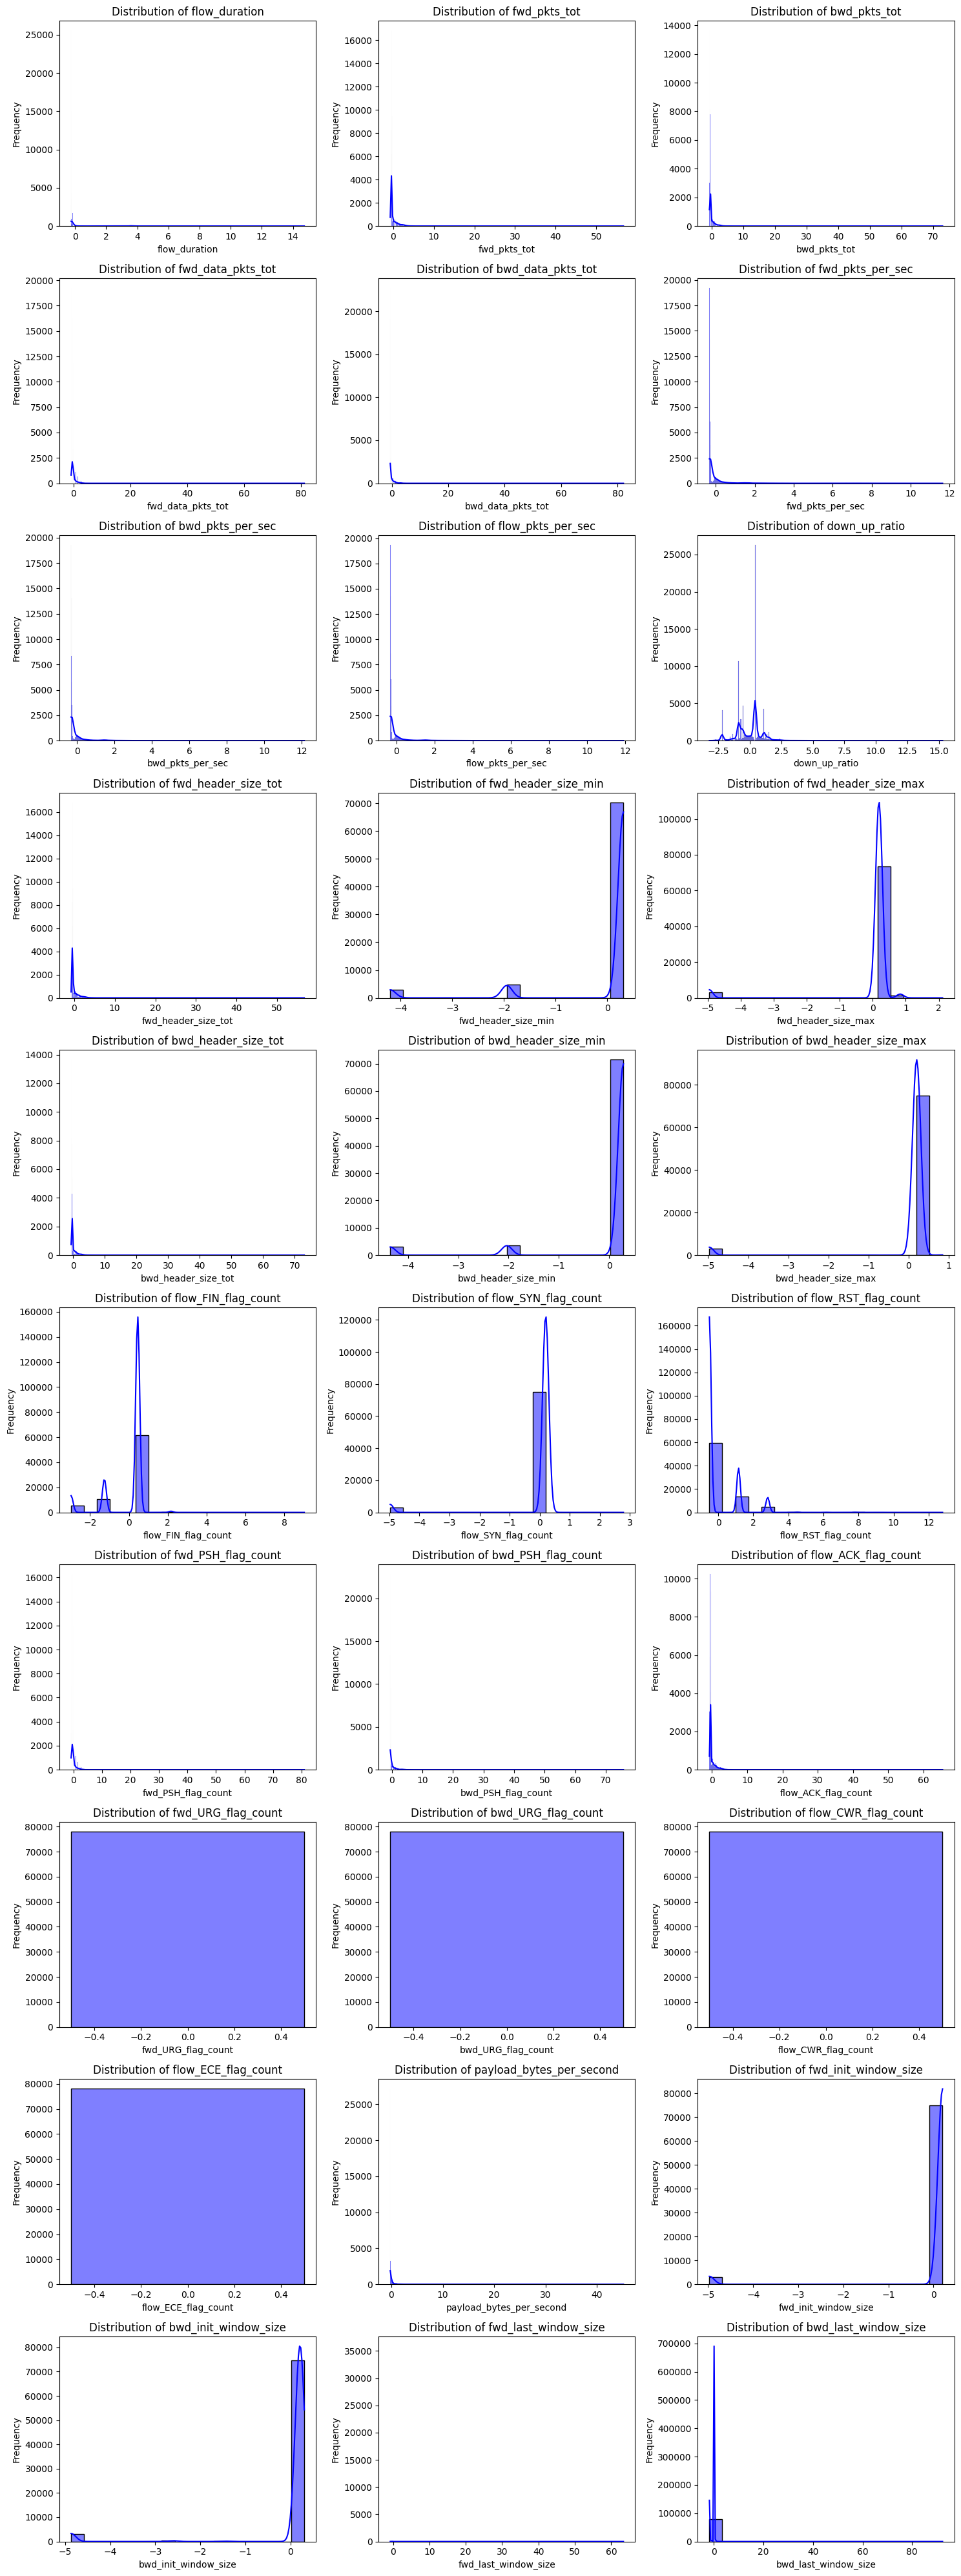

In [10]:
plot_feature_distribution_grid(df=X, features=X.columns, color="blue", cols=3)

### Distribution after MinMaxScaler Normalisation [🏠](#data-cleaning-and-preprocessing) <a id="distribution-after-minmaxscaler-normalisation"></a>

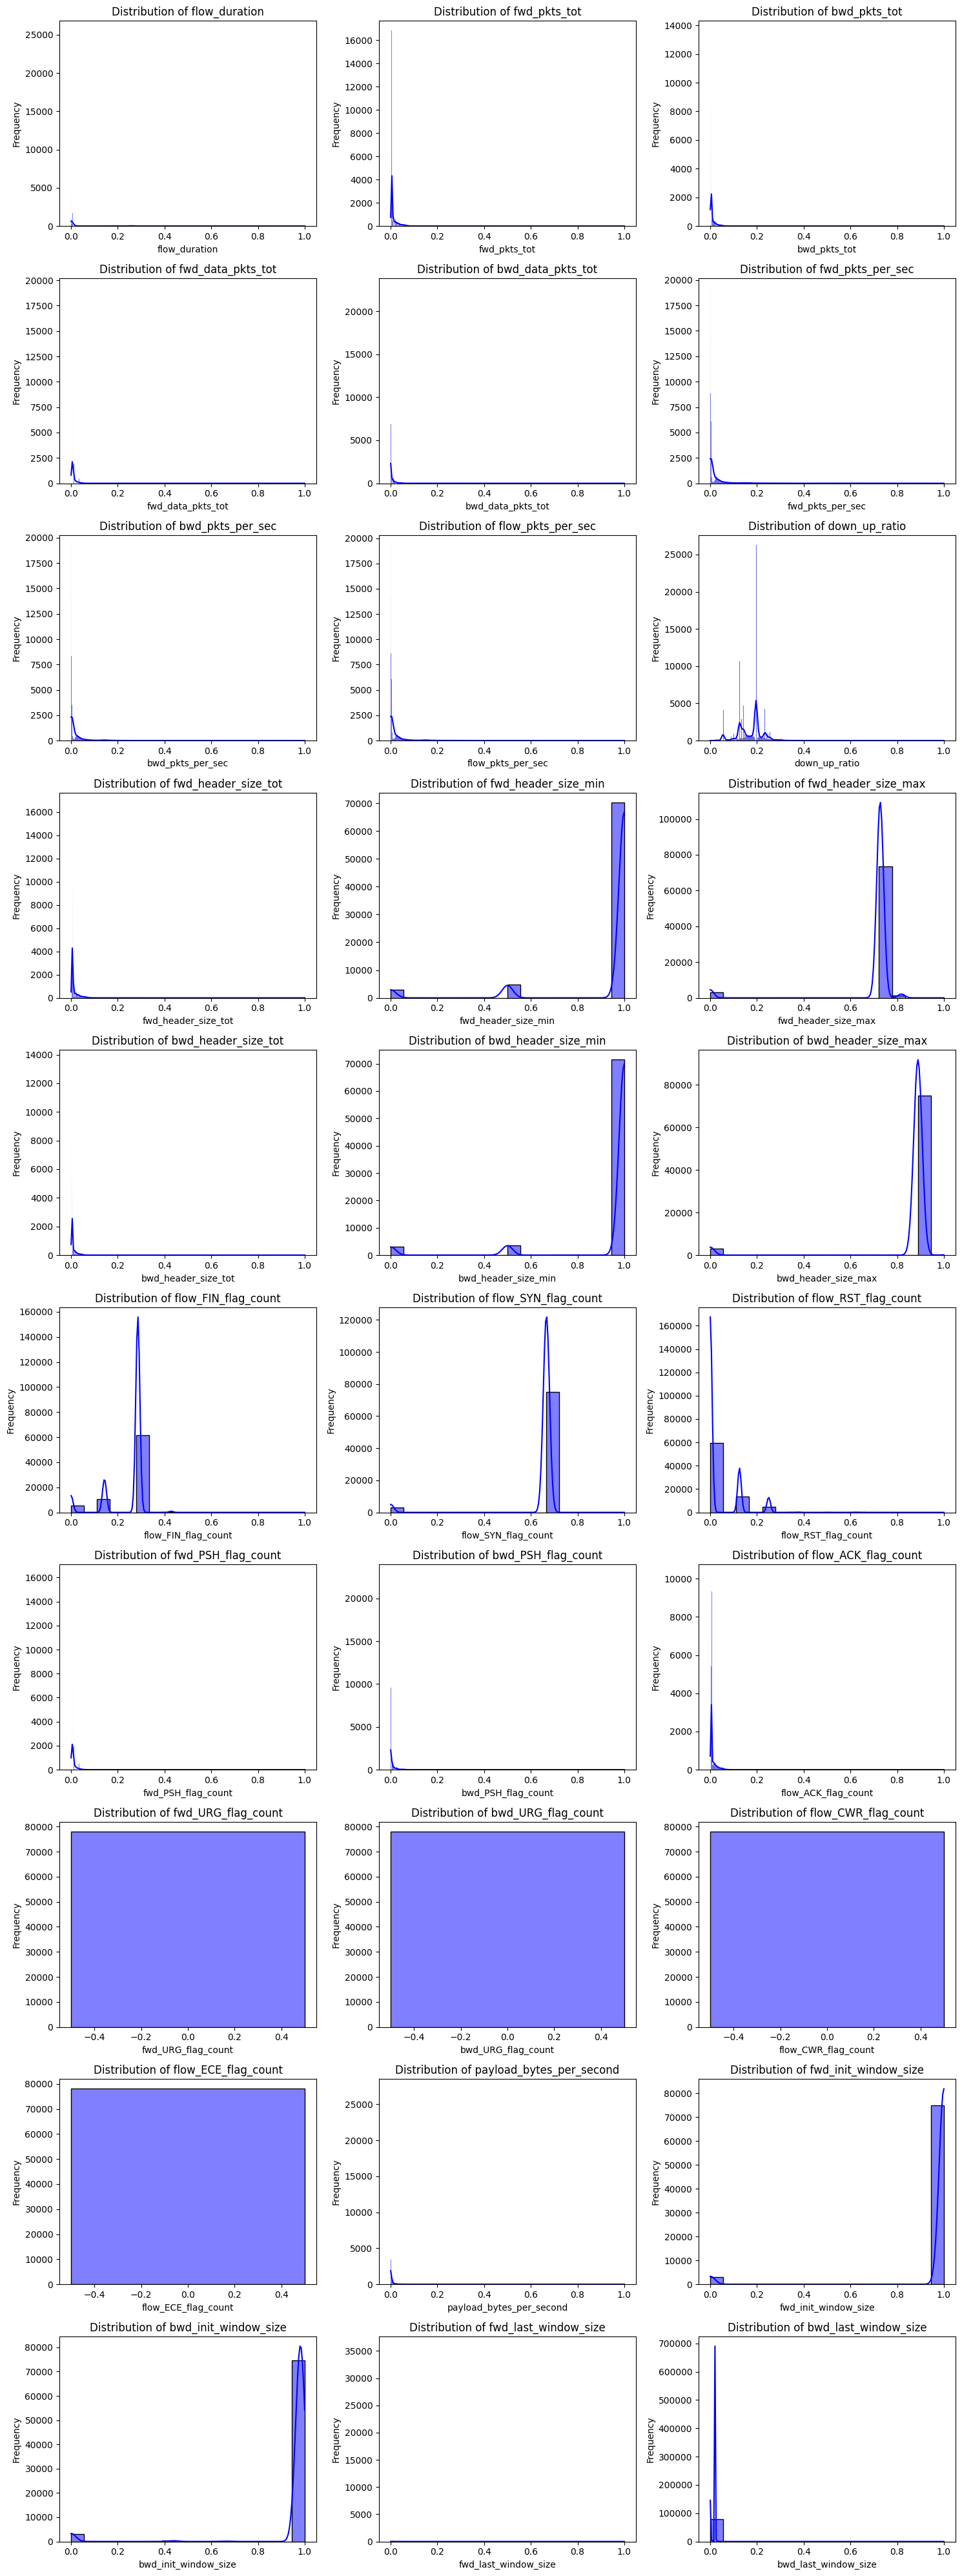

In [11]:
mm_scaler = MinMaxScaler()
X_mm_scaled = mm_scaler.fit_transform(X)
X_mm_scaled = pd.DataFrame(X_mm_scaled, columns=X.columns)

plot_feature_distribution_grid(df=X_mm_scaled, features=X_mm_scaled.columns, color="blue", cols=3)

### Train and Evaluate the Model [🏠](#data-cleaning-and-preprocessing) <a id="train-and-evaluate-the-model" ></a>

In [ ]:
# Selected features based on bwd analysis and domain knowledge  
selected_features = [
    'bwd_header_size_min', 
    'fwd_header_size_max', 
    'bwd_data_pkts_tot', 
    'flow_FIN_flag_count', 
    'flow_RST_flag_count', 
    'payload_bytes_per_second', 
    'flow_duration', 
    'bwd_PSH_flag_count'
    ]  

# Define classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC linear": SVC(kernel='linear'),
    "SVC RBF": SVC(kernel='rbf'),
    "SVC Poly": SVC(kernel='poly'),
    "K-Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
}

Training Random Forest...

Random Forest Classification Report:
                      precision    recall  f1-score   support

              benign       0.98      0.96      0.97       911
     bruteforce_http       1.00      1.00      1.00      1003
    bruteforce_https       1.00      1.00      1.00      1009
            dos_http       0.96      0.93      0.94       937
           dos_https       0.95      0.95      0.95       998
           ftp_login       1.00      1.00      1.00       986
       revshell_http       0.77      0.76      0.76       991
      revshell_https       0.75      0.76      0.76       968
  sql_injection_http       0.88      0.89      0.89      1027
 sql_injection_https       0.96      0.98      0.97       997
           ssh_login       0.49      0.56      0.53       998
ssh_login_successful       0.50      0.44      0.47      1019
           ssrf_http       0.71      0.72      0.71       995
          ssrf_https       0.78      0.74      0.76       943
     

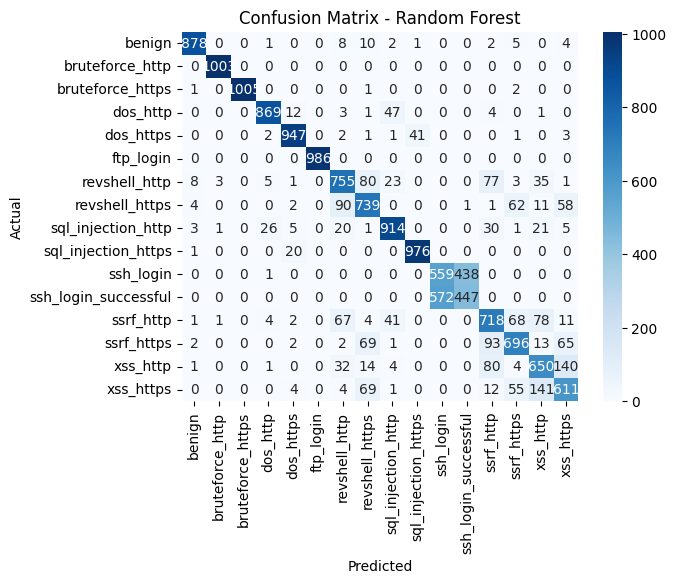

Training Gradient Boosting...

Gradient Boosting Classification Report:
                      precision    recall  f1-score   support

              benign       0.98      0.95      0.97       911
     bruteforce_http       0.99      1.00      0.99      1003
    bruteforce_https       1.00      1.00      1.00      1009
            dos_http       0.96      0.79      0.87       937
           dos_https       0.93      0.84      0.88       998
           ftp_login       1.00      1.00      1.00       986
       revshell_http       0.79      0.76      0.78       991
      revshell_https       0.81      0.67      0.73       968
  sql_injection_http       0.71      0.92      0.80      1027
 sql_injection_https       0.86      0.95      0.91       997
           ssh_login       0.50      0.35      0.41       998
ssh_login_successful       0.51      0.66      0.57      1019
           ssrf_http       0.73      0.73      0.73       995
          ssrf_https       0.67      0.78      0.73       9

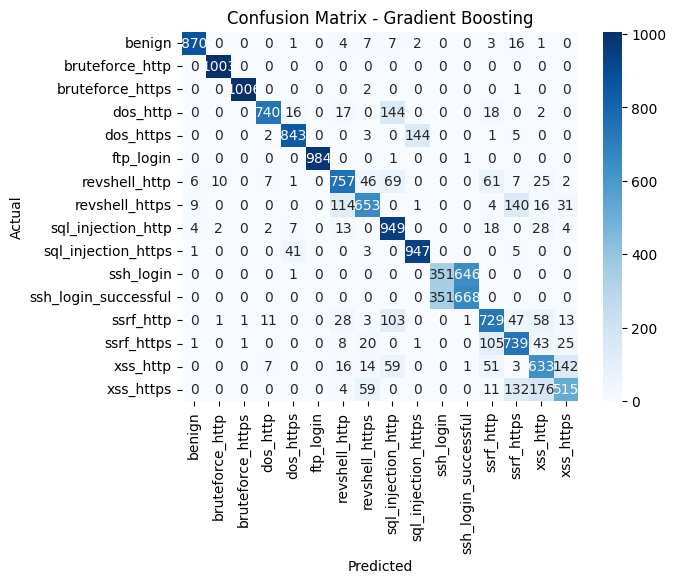

Training Logistic Regression...


c:\Accadamics\Software tools\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Classification Report:
                      precision    recall  f1-score   support

              benign       0.95      0.82      0.88       911
     bruteforce_http       0.64      1.00      0.78      1003
    bruteforce_https       0.70      1.00      0.82      1009
            dos_http       0.28      0.25      0.26       937
           dos_https       0.87      0.62      0.73       998
           ftp_login       0.63      1.00      0.77       986
       revshell_http       0.48      0.43      0.46       991
      revshell_https       0.49      0.19      0.27       968
  sql_injection_http       0.49      0.48      0.48      1027
 sql_injection_https       0.74      0.93      0.82       997
           ssh_login       0.47      1.00      0.64       998
ssh_login_successful       0.00      0.00      0.00      1019
           ssrf_http       0.40      0.62      0.49       995
          ssrf_https       0.57      0.32      0.41       943
            xss_http     

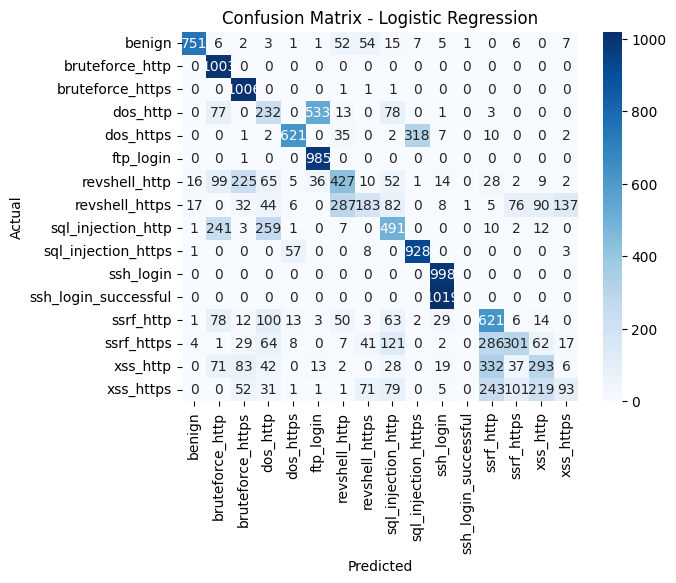

Training SVC linear...

SVC linear Classification Report:


c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools

                      precision    recall  f1-score   support

              benign       0.96      0.88      0.91       911
     bruteforce_http       0.74      1.00      0.85      1003
    bruteforce_https       0.85      1.00      0.91      1009
            dos_http       0.87      0.76      0.81       937
           dos_https       0.91      0.60      0.72       998
           ftp_login       0.95      1.00      0.98       986
       revshell_http       0.59      0.43      0.50       991
      revshell_https       0.73      0.22      0.34       968
  sql_injection_http       0.49      0.87      0.63      1027
 sql_injection_https       0.74      0.97      0.84       997
           ssh_login       0.48      1.00      0.65       998
ssh_login_successful       0.00      0.00      0.00      1019
           ssrf_http       0.43      0.67      0.52       995
          ssrf_https       0.60      0.30      0.40       943
            xss_http       0.41      0.45      0.43       926
       

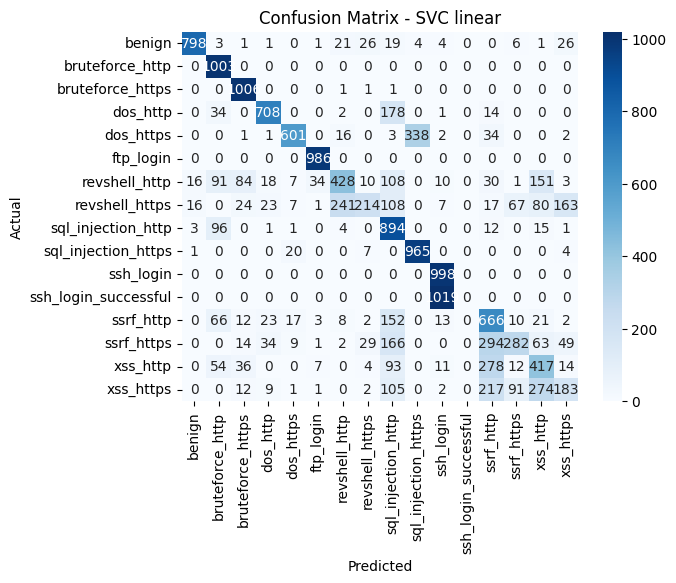

Training SVC RBF...

SVC RBF Classification Report:


c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

              benign       0.96      0.95      0.96       911
     bruteforce_http       0.71      1.00      0.83      1003
    bruteforce_https       0.81      1.00      0.89      1009
            dos_http       0.95      0.75      0.84       937
           dos_https       0.97      0.59      0.73       998
           ftp_login       0.95      1.00      0.97       986
       revshell_http       0.69      0.36      0.47       991
      revshell_https       0.68      0.50      0.57       968
  sql_injection_http       0.50      0.82      0.62      1027
 sql_injection_https       0.73      0.98      0.84       997
           ssh_login       0.46      1.00      0.63       998
ssh_login_successful       0.00      0.00      0.00      1019
           ssrf_http       0.62      0.52      0.57       995
          ssrf_https       0.76      0.46      0.57       943
            xss_http       0.40      0.55      0.46       926
       

c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


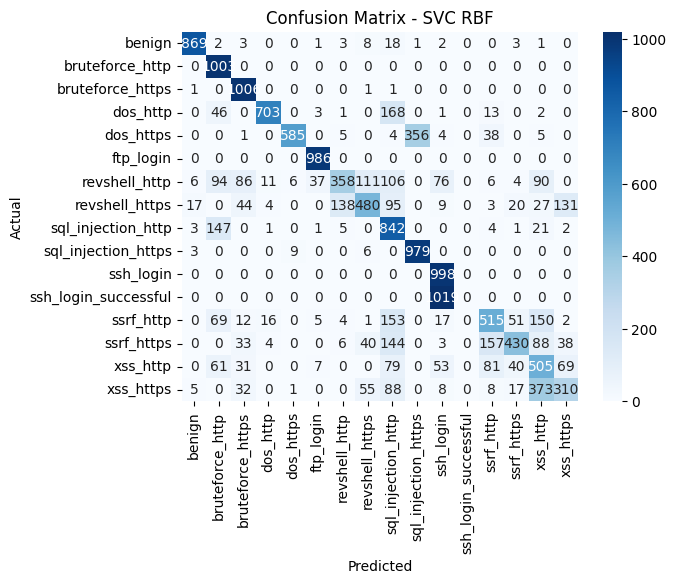

Training SVC Poly...

SVC Poly Classification Report:


c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

              benign       0.94      0.90      0.92       911
     bruteforce_http       0.33      0.02      0.04      1003
    bruteforce_https       0.98      0.05      0.10      1009
            dos_http       0.75      0.17      0.28       937
           dos_https       0.98      0.58      0.73       998
           ftp_login       0.24      1.00      0.39       986
       revshell_http       0.64      0.32      0.42       991
      revshell_https       0.71      0.44      0.55       968
  sql_injection_http       0.43      0.29      0.35      1027
 sql_injection_https       0.72      0.98      0.83       997
           ssh_login       0.28      1.00      0.44       998
ssh_login_successful       0.00      0.00      0.00      1019
           ssrf_http       0.53      0.35      0.42       995
          ssrf_https       0.84      0.33      0.47       943
            xss_http       0.30      0.53      0.38       926
       

c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


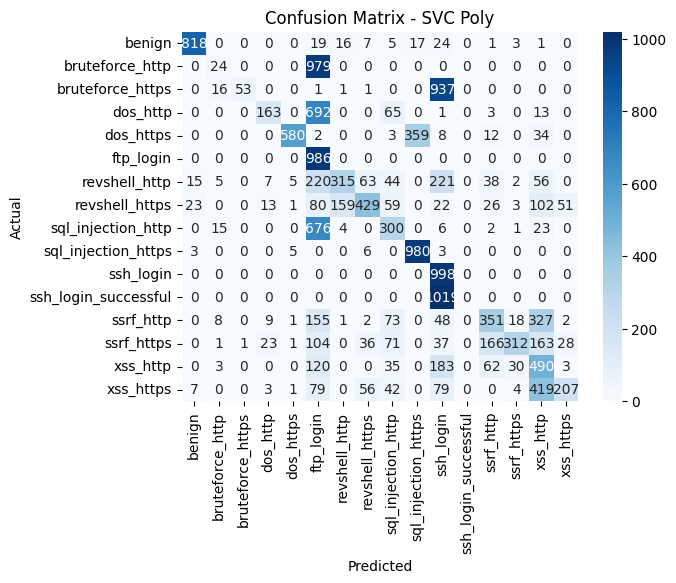

Training K-Neighbors...

K-Neighbors Classification Report:
                      precision    recall  f1-score   support

              benign       0.97      0.96      0.96       911
     bruteforce_http       0.99      1.00      1.00      1003
    bruteforce_https       1.00      1.00      1.00      1009
            dos_http       0.82      0.79      0.81       937
           dos_https       0.84      0.76      0.80       998
           ftp_login       1.00      1.00      1.00       986
       revshell_http       0.72      0.69      0.70       991
      revshell_https       0.64      0.68      0.66       968
  sql_injection_http       0.71      0.85      0.77      1027
 sql_injection_https       0.80      0.86      0.83       997
           ssh_login       0.51      0.52      0.51       998
ssh_login_successful       0.52      0.52      0.52      1019
           ssrf_http       0.69      0.65      0.67       995
          ssrf_https       0.71      0.67      0.69       943
         

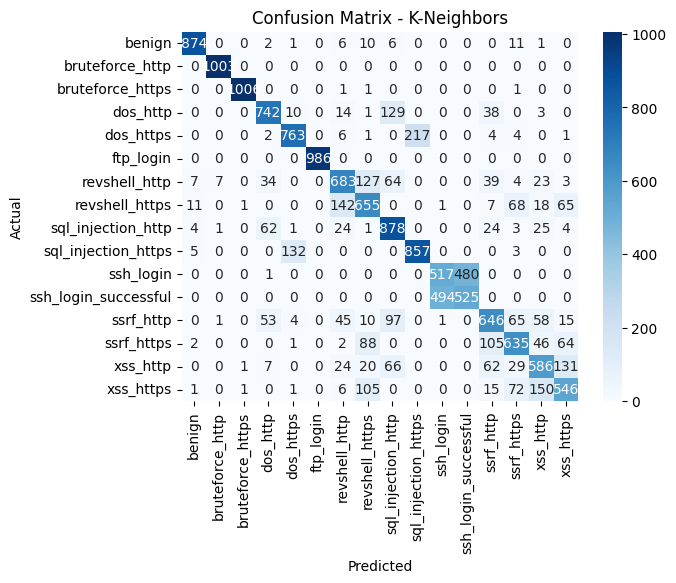

Training Decision Tree...

Decision Tree Classification Report:
                      precision    recall  f1-score   support

              benign       0.97      0.95      0.96       911
     bruteforce_http       1.00      1.00      1.00      1003
    bruteforce_https       1.00      1.00      1.00      1009
            dos_http       0.92      0.93      0.93       937
           dos_https       0.94      0.94      0.94       998
           ftp_login       1.00      1.00      1.00       986
       revshell_http       0.73      0.71      0.72       991
      revshell_https       0.69      0.72      0.70       968
  sql_injection_http       0.86      0.85      0.86      1027
 sql_injection_https       0.95      0.97      0.96       997
           ssh_login       0.50      0.58      0.54       998
ssh_login_successful       0.52      0.44      0.47      1019
           ssrf_http       0.67      0.67      0.67       995
          ssrf_https       0.72      0.71      0.72       943
     

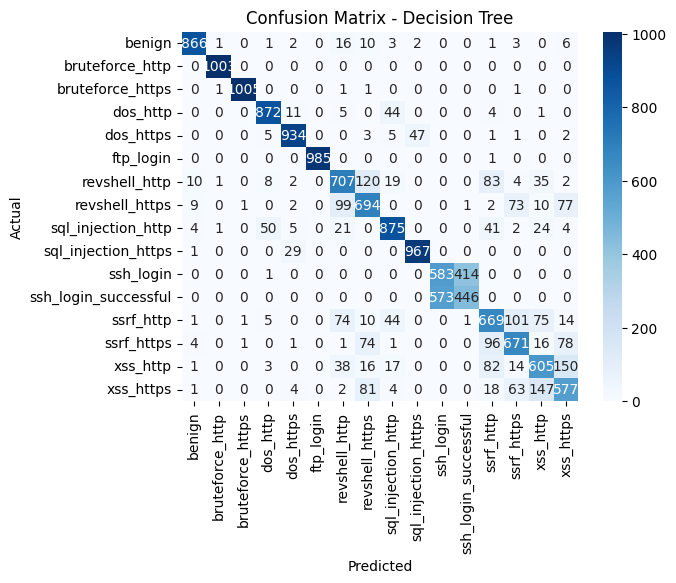

Training Gaussian Naive Bayes...

Gaussian Naive Bayes Classification Report:


c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools

                      precision    recall  f1-score   support

              benign       0.96      0.68      0.79       911
     bruteforce_http       1.00      0.02      0.05      1003
    bruteforce_https       0.96      0.05      0.10      1009
            dos_http       0.15      0.98      0.26       937
           dos_https       0.96      0.58      0.72       998
           ftp_login       0.96      1.00      0.98       986
       revshell_http       0.46      0.39      0.43       991
      revshell_https       0.58      0.20      0.30       968
  sql_injection_http       0.01      0.01      0.01      1027
 sql_injection_https       0.72      0.98      0.83       997
           ssh_login       0.49      1.00      0.66       998
ssh_login_successful       0.00      0.00      0.00      1019
           ssrf_http       0.27      0.05      0.09       995
          ssrf_https       0.89      0.02      0.04       943
            xss_http       0.29      0.28      0.28       926
       

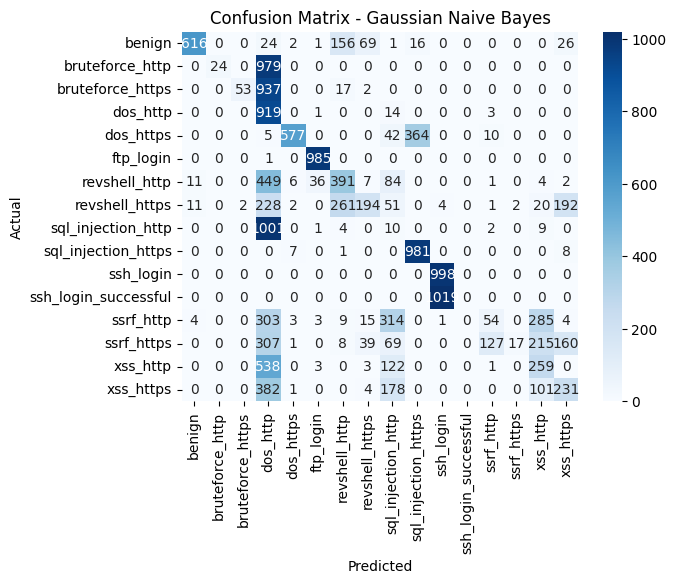

In [ ]:
# Train and evaluate models
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=selected_features, 
                    classifiers=classifiers
                    )

### Dimentionality Reduced data for model training [🏠](#data-cleaning-and-preprocessing) <a id="dimentionality-reduced-data-for-model-training" ></a>

In [15]:
# x_pca = PCA(n_components=3).fit_transform(X[top_features])
# x_tsne = TSNE(n_components=3, random_state=42).fit_transform(X[top_features])
# x_umap = UMAP(n_components=3, random_state=42).fit_transform(X[top_features])

### Boosting Classifiers Training [🏠](#data-cleaning-and-preprocessing) <a id="boosting-classifiers-training"></a>

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       911
           1       1.00      1.00      1.00      1003
           2       1.00      1.00      1.00      1009
           3       0.95      0.86      0.91       937
           4       0.94      0.92      0.93       998
           5       1.00      1.00      1.00       986
           6       0.79      0.74      0.76       991
           7       0.78      0.71      0.74       968
           8       0.81      0.91      0.86      1027
           9       0.93      0.95      0.94       997
          10       0.50      0.57      0.54       998
          11       0.52      0.45      0.48      1019
          12       0.72      0.73      0.73       995
          13       0.76      0.74      0.75       943
          14       0.67      0.72      0.69       926
          15       0.66      0.71      0.68       897

    accuracy                

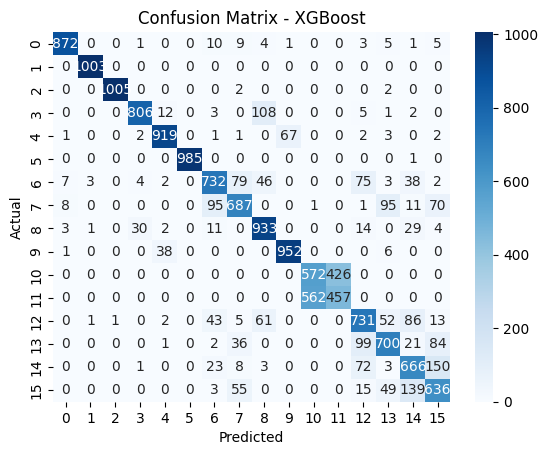

Training CatBoost...

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       911
           1       0.98      1.00      0.99      1003
           2       0.99      1.00      0.99      1009
           3       0.97      0.82      0.89       937
           4       0.94      0.85      0.89       998
           5       1.00      1.00      1.00       986
           6       0.80      0.74      0.77       991
           7       0.79      0.70      0.74       968
           8       0.75      0.91      0.82      1027
           9       0.87      0.96      0.91       997
          10       0.50      0.51      0.51       998
          11       0.52      0.51      0.51      1019
          12       0.71      0.74      0.72       995
          13       0.74      0.76      0.75       943
          14       0.67      0.73      0.70       926
          15       0.70      0.69      0.69       897

    accuracy              

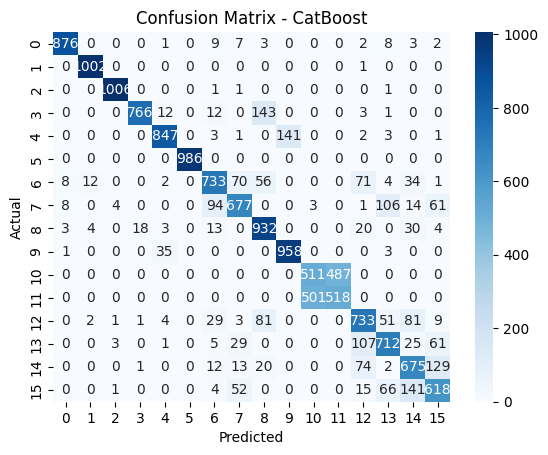

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 62416, number of used features: 8
[LightGBM] [Info] Start training from score -2.806747
[LightGBM] [Info] Start training from score -2.748278
[LightGBM] [Info] Start training from score -2.749780
[LightGBM] [Info] Start training from score -2.733624
[LightGBM] [Info] Start training from score -2.752289
[LightGBM] [Info] Start training from score -2.744033
[LightGBM] [Info] Start training from score -2.821443
[LightGBM] [Info] Start training from score -2.810201
[LightGBM] [Info] Start training from score -2.755307
[LightGBM] [Info] Start training from score -2.746778
[LightGBM] [Info] Start training from score -2.747027
[LightGBM] [Info] Start training f

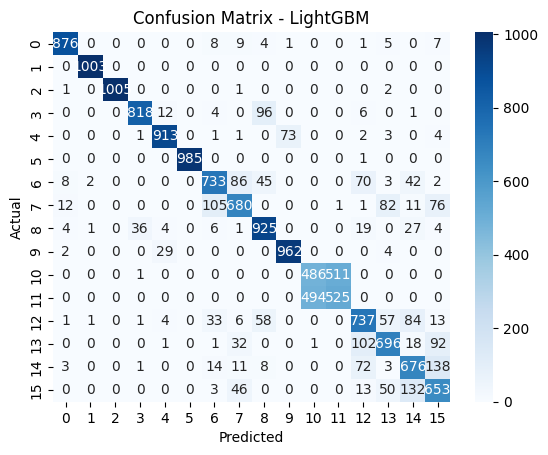

Training AdaBoost...


c:\Accadamics\Software tools\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.52      0.29       911
           1       0.00      0.00      0.00      1003
           2       0.00      0.00      0.00      1009
           3       0.20      0.59      0.30       937
           4       0.00      0.00      0.00       998
           5       0.00      0.00      0.00       986
           6       0.40      0.49      0.44       991
           7       0.00      0.00      0.00       968
           8       0.00      0.00      0.00      1027
           9       0.41      0.99      0.58       997
          10       0.15      1.00      0.25       998
          11       0.00      0.00      0.00      1019
          12       0.00      0.00      0.00       995
          13       0.00      0.00      0.00       943
          14       0.00      0.00      0.00       926
          15       0.00      0.00      0.00       897

    accuracy                           0.22    

c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Accadamics\Software tools

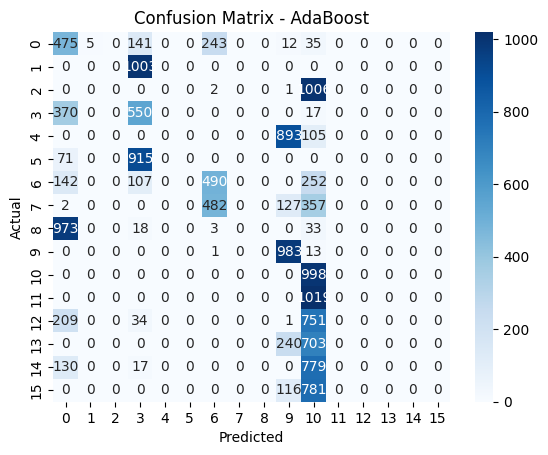

In [ ]:
# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_attack_type)

trained_xgb_clf, xgb_performance_dict = train_and_evaluate_model(
    X,
    y_encoded,
    top_features=selected_features,
    classifiers={
        "XGBoost": XGBClassifier(use_label_encoder=label_encoder, eval_metric='mlogloss'),
        "CatBoost": CatBoostClassifier(verbose=0, random_seed=42),
        "LightGBM": LGBMClassifier(),
        "AdaBoost": AdaBoostClassifier()
    }
)

### K-Nearest Neighbour [🏠](#data-cleaning-and-preprocessing) <a id="k-nearest-neighbour"></a>

Training K-Neighbors...

K-Neighbors Classification Report:
                      precision    recall  f1-score   support

              benign       0.97      0.96      0.96       911
     bruteforce_http       0.99      1.00      1.00      1003
    bruteforce_https       1.00      1.00      1.00      1009
            dos_http       0.82      0.79      0.81       937
           dos_https       0.84      0.76      0.80       998
           ftp_login       1.00      1.00      1.00       986
       revshell_http       0.72      0.69      0.70       991
      revshell_https       0.64      0.68      0.66       968
  sql_injection_http       0.71      0.85      0.77      1027
 sql_injection_https       0.80      0.86      0.83       997
           ssh_login       0.51      0.52      0.51       998
ssh_login_successful       0.52      0.52      0.52      1019
           ssrf_http       0.69      0.65      0.67       995
          ssrf_https       0.71      0.67      0.69       943
         

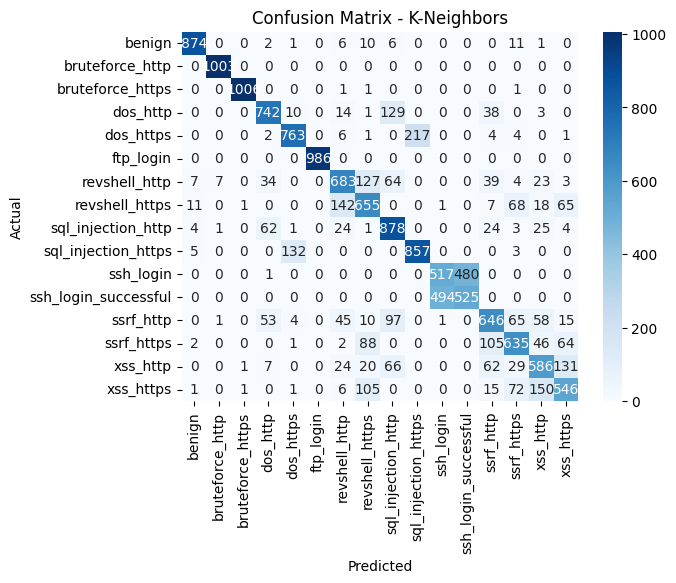

In [ ]:
trained_KNN_clf, knn_performance_dict = train_and_evaluate_model(
    X,
    y_attack_type,
    top_features=selected_features,
    classifiers={
        "K-Neighbors": KNeighborsClassifier(n_neighbors=5),
    }
)

### Performance Comparison [🏠](#data-cleaning-and-preprocessing) <a id="performance-comparison"></a>

In [18]:
performace_dict_1.update(xgb_performance_dict)

# Put the performance metrics into a DataFrame for better visualization
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)

Performance Metrics:
                      accuracy  f1_score  precision    recall
Random Forest         0.817238  0.817172   0.817810  0.817238
LightGBM              0.812112  0.812452   0.814161  0.812112
XGBoost               0.811022  0.811227   0.813329  0.811022
CatBoost              0.804229  0.804398   0.807585  0.804229
Decision Tree         0.798398  0.798116   0.798736  0.798398
Gradient Boosting     0.793784  0.791940   0.798380  0.793784
K-Neighbors           0.762704  0.762067   0.763064  0.762704
SVC RBF               0.677283  0.647974   0.669321  0.677283
SVC linear            0.650368  0.611376   0.632688  0.650368
Logistic Regression   0.572445  0.523128   0.528819  0.572445
SVC Poly              0.448959  0.414351   0.582656  0.448959
Gaussian Naive Bayes  0.404293  0.363367   0.567421  0.404293
AdaBoost              0.224031  0.116314   0.084819  0.224031


## GPU

In [ ]:
# cell 1
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# GPU-accelerated libraries
try:
    # RAPIDS cuML for GPU acceleration
    from cuml.ensemble import RandomForestClassifier as cumlRandomForestClassifier
    from cuml.linear_model import LogisticRegression as cumlLogisticRegression
    from cuml.svm import SVC as cumlSVC
    from cuml.neighbors import KNeighborsClassifier as cumlKNeighborsClassifier
    from cuml.naive_bayes import GaussianNB as cumlGaussianNB
    CUML_AVAILABLE = True
    print("RAPIDS cuML is available - GPU acceleration enabled")
except ImportError:
    CUML_AVAILABLE = False
    print("RAPIDS cuML not available - falling back to CPU implementations")

# XGBoost with GPU support
from xgboost import XGBClassifier

# CatBoost with GPU support
from catboost import CatBoostClassifier

# LightGBM with GPU support
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Check GPU availability
import subprocess
import sys

def check_gpu_availability():
    """Check if CUDA is available and display GPU information"""
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("CUDA GPU detected:")
            print(result.stdout.split('\n')[8:12])  # GPU info lines
            return True
        else:
            print("No CUDA GPU detected")
            return False
    except FileNotFoundError:
        print("nvidia-smi not found - no CUDA GPU available")
        return False

GPU_AVAILABLE = check_gpu_availability()

# cell 2
def load_top_rows_from_csvs(folder_path, n_rows=5000):
    """
    Reads the first `n_rows` from each CSV in the specified folder
    and concatenates them into a single DataFrame.

    Note: It omits the "web-ids23_smtp_enum.csv" file as it contains only 7 rows.
    
    Parameters:
        folder_path (str): Path to the folder containing CSV files.
        n_rows (int): Number of rows to read from each file.

    Returns:
        pd.DataFrame: Combined DataFrame from all CSVs.
    """
    all_dfs = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and filename not in ["web-ids23_smtp_enum.csv", "ssh_login.csv", "ssh_login_successful.csv"]:
            file_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(file_path, nrows=n_rows)
                all_dfs.append(df)
                print(f"{filename} loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
            except Exception as e:
                print(f"Could not read {filename}: {e}")
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

def preprocess_data(df, columns_2_drop, target_columns=['attack_type', 'attack']):
    """
    Preprocess the DataFrame by handling missing values, encoding categorical variables,
    and scaling numerical features.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    target_column (str): Name of the target variable column.
    columns_2_drop (list): List of columns to drop from the DataFrame.

    Returns:
    X (pd.DataFrame): Features DataFrame.
    y_1 (pd.Series): Target variable Series.
    y_2 (pd.Series): Second target variable Series.
    """
    # Handle missing values
    df = df.dropna(axis=0, how='any')  # Drop rows with any missing values

    # Separate features and target variable
    y_1 = df[target_columns[0]]  # attack_type
    y_2 = df[target_columns[1]]  # attack
    X = df.drop(columns=target_columns)

    # Drop some columns that are not needed for analysis
    print(f"Dropping columns: {columns_2_drop}") # df.columns[0:4])
    X = X.drop(columns=columns_2_drop)

    # Encode categorical variables if any
    X = pd.get_dummies(X, drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return pd.DataFrame(X_scaled, columns=X.columns), pd.Series(y_1), pd.Series(y_2)

def visualize_covariance_matrix(X, color="Blues"):
    """
    Visualize the covariance matrix of the features in the DataFrame.

    Parameters:
    X (pd.DataFrame): Features DataFrame.
    color (str): Color map for the heatmap.

    Returns:
    None
    """
    covariance_matrix = X.cov()
    return covariance_matrix

def get_gpu_classifiers():
    """Get GPU-accelerated classifiers if available, otherwise return CPU versions"""
    
    gpu_classifiers = {}
    
    if CUML_AVAILABLE:
        # Use cuML GPU-accelerated classifiers
        gpu_classifiers.update({
            "Random Forest (GPU)": cumlRandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42
            ),
            "Logistic Regression (GPU)": cumlLogisticRegression(
                max_iter=1000,
                random_state=42
            ),
            "SVC Linear (GPU)": cumlSVC(
                kernel='linear',
                random_state=42
            ),
            "SVC RBF (GPU)": cumlSVC(
                kernel='rbf',
                random_state=42
            ),
            "K-Neighbors (GPU)": cumlKNeighborsClassifier(
                n_neighbors=5
            ),
            "Gaussian Naive Bayes (GPU)": cumlGaussianNB()
        })
    
    # XGBoost with GPU support
    if GPU_AVAILABLE:
        gpu_classifiers["XGBoost (GPU)"] = XGBClassifier(
            tree_method='gpu_hist',
            gpu_id=0,
            eval_metric='mlogloss',
            random_state=42
        )
        
        # CatBoost with GPU support
        gpu_classifiers["CatBoost (GPU)"] = CatBoostClassifier(
            task_type='GPU',
            devices='0',
            verbose=0,
            random_seed=42
        )
        
        # LightGBM with GPU support
        gpu_classifiers["LightGBM (GPU)"] = LGBMClassifier(
            device='gpu',
            random_state=42
        )
    else:
        # Fallback to CPU versions
        gpu_classifiers.update({
            "XGBoost (CPU)": XGBClassifier(eval_metric='mlogloss', random_state=42),
            "CatBoost (CPU)": CatBoostClassifier(verbose=0, random_seed=42),
            "LightGBM (CPU)": LGBMClassifier(random_state=42)
        })
    
    # CPU-only classifiers (these don't have GPU equivalents in cuML or are better on CPU)
    cpu_classifiers = {
        "Random Forest (CPU)": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42)
    }
    
    # If cuML is not available, add CPU versions of the classifiers
    if not CUML_AVAILABLE:
        cpu_classifiers.update({
            "Logistic Regression (CPU)": LogisticRegression(random_state=42),
            "SVC Linear (CPU)": SVC(kernel='linear', random_state=42),
            "SVC RBF (CPU)": SVC(kernel='rbf', random_state=42),
            "K-Neighbors (CPU)": KNeighborsClassifier(n_neighbors=5),
            "Gaussian Naive Bayes (CPU)": GaussianNB()
        })
    
    # Combine GPU and CPU classifiers
    all_classifiers = {**gpu_classifiers, **cpu_classifiers}
    
    return all_classifiers

def convert_to_numpy_if_needed(X, y):
    """Convert pandas DataFrame/Series to numpy arrays for cuML compatibility"""
    if CUML_AVAILABLE:
        # cuML works better with numpy arrays
        X_np = X.values if hasattr(X, 'values') else X
        y_np = y.values if hasattr(y, 'values') else y
        return X_np, y_np
    return X, y

def train_and_evaluate_model(X, y, color="Blues", top_features=None, classifiers=None):
    """
    Train and evaluate multiple classifiers on the given dataset with GPU support.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    top_features (list, optional): List of top features to select. If None, all features are used.
    classifiers (dict): Dictionary of classifiers to use.

    Returns:
    tuple: (trained_classifiers, performance_dict)
    """

    # Select top features if provided
    if top_features is None:
        top_features = X.columns.tolist()  # Use all features if no specific ones are provided
    X_selected = X[top_features]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    trained_clfs = {}
    performance_dict = {}

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        print(f"Training {name}...")
        
        try:
            # Convert to numpy arrays for cuML models
            if "(GPU)" in name and CUML_AVAILABLE:
                X_train_converted, y_train_converted = convert_to_numpy_if_needed(X_train, y_train)
                X_test_converted, y_test_converted = convert_to_numpy_if_needed(X_test, y_test)
                
                clf.fit(X_train_converted, y_train_converted)
                y_pred = clf.predict(X_test_converted)
                
                # Convert predictions back to pandas if needed
                if hasattr(y_pred, 'values'):
                    y_pred = y_pred.values
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
            
            trained_clfs[name] = clf
            
            # Print classification report
            print(f"\n{name} Classification Report:")
            print(classification_report(y_test, y_pred))

            # Store the performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')

            performance_dict[name] = {
                'accuracy': accuracy,
                'f1_score': f1,
                'precision': precision,
                'recall': recall
            }

            # Print confusion matrix
            print("Confusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            
            # Get unique classes for labels
            if hasattr(clf, 'classes_'):
                classes = clf.classes_
            else:
                classes = sorted(list(set(y_test.unique()) | set(y_pred)))
            
            # Plot confusion matrix heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                        xticklabels=classes, yticklabels=classes)
            plt.title(f"Confusion Matrix - {name}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue

    return trained_clfs, performance_dict

def visualize_feature_importances(X, classifier):
    """
    Visualize feature importances for a given classifier.
    Parameters:
    X (pd.DataFrame): Features.
    classifier: The trained classifier with feature importances.
    Returns:
    None
    """
    # Check if classifier has feature importances
    if hasattr(classifier, 'feature_importances_'):
        plt.figure(figsize=(12, 8))
        importances = classifier.feature_importances_
        indices = importances.argsort()[::-1]
        plt.title(f"Feature Importances - {classifier.__class__.__name__}")
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{classifier.__class__.__name__} does not have feature_importances_ attribute")

def print_low_performance_classes(report, threshold=0.7):
    """
    Print classes with precision, recall, and f1-score below a specified threshold.

    Parameters:
    report (dict): Classification report from sklearn.
    threshold (float): Threshold for filtering classes.

    Returns:
    None
    """
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
            f1_score = metrics.get('f1-score', 0)
            if precision < threshold or recall < threshold or f1_score < threshold:
                print(f"Class: {class_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

def plot_feature_distribution_grid(df, features, cols=3, color="blue"):
    """
    Plot the distribution of multiple features in a grid layout.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    features (list): List of feature names to plot.
    cols (int): Number of plots per row.
    color (str): Color for the plots.
    
    Returns:
    None
    """
    num_features = len(features)
    rows = (num_features + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of multi-row layout

    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=True, color=color, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# cell 3
df_balanced = load_top_rows_from_csvs("E:\\Accadamics\\Semesters\\Final Year Project\\Data\\web-ids23")

# Drop columns that are not needed for analysis
columns_2_drop = [
    'uid',               # Unique flow ID (not predictive)
    'ts',                # Timestamp (not useful directly; time-series analysis might use it differently)
    'id.orig_h',         # Origin IP — environment-specific
    'id.resp_h',         # Destination IP — environment-specific
    'service',           # Tool-specific, may not generalize
    'traffic_direction', # Typically derived from IPs — not generalizable
]

target_columns = ['attack_type', 'attack']  # Define target columns
X, y_attack_type, y_attack = preprocess_data(df_balanced, columns_2_drop=columns_2_drop, target_columns=target_columns)

# Visualize covariance matrix
cov_matrix = visualize_covariance_matrix(X, color="Reds")
print("Covariance matrix:\n", cov_matrix)

plot_feature_distribution_grid(df=X, features=X.columns, color="blue", cols=3)

mm_scaler = MinMaxScaler()
X_mm_scaled = mm_scaler.fit_transform(X)
X_mm_scaled = pd.DataFrame(X_mm_scaled, columns=X.columns)

plot_feature_distribution_grid(df=X_mm_scaled, features=X_mm_scaled.columns, color="blue", cols=3)

# Cell 4
# Selected features based on bwd analysis and domain knowledge  
selected_features = [
    'bwd_header_size_min', 
    'fwd_header_size_max', 
    'bwd_data_pkts_tot', 
    'flow_FIN_flag_count', 
    'flow_RST_flag_count', 
    'payload_bytes_per_second', 
    'flow_duration', 
    'bwd_PSH_flag_count'
]  

# Get GPU-accelerated classifiers
all_classifiers = get_gpu_classifiers()

# Train and evaluate models with GPU acceleration
trained_clfs, performance_dict_1 = train_and_evaluate_model(
    X, 
    y_attack_type, 
    top_features=selected_features, 
    classifiers=all_classifiers
)

# Cell 5
# Encode string labels into integers for models that require it
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_attack_type)

# Additional GPU-accelerated models
additional_gpu_classifiers = {}

if GPU_AVAILABLE:
    additional_gpu_classifiers.update({
        "XGBoost Advanced (GPU)": XGBClassifier(
            tree_method='gpu_hist',
            gpu_id=0,
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            eval_metric='mlogloss',
            random_state=42
        ),
        "CatBoost Advanced (GPU)": CatBoostClassifier(
            task_type='GPU',
            devices='0',
            iterations=200,
            depth=8,
            learning_rate=0.1,
            verbose=0,
            random_seed=42
        ),
        "LightGBM Advanced (GPU)": LGBMClassifier(
            device='gpu',
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            random_state=42
        )
    })
else:
    additional_gpu_classifiers.update({
        "XGBoost Advanced (CPU)": XGBClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            eval_metric='mlogloss',
            random_state=42
        ),
        "CatBoost Advanced (CPU)": CatBoostClassifier(
            iterations=200,
            depth=8,
            learning_rate=0.1,
            verbose=0,
            random_seed=42
        ),
        "LightGBM Advanced (CPU)": LGBMClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            random_state=42
        )
    })

# Add AdaBoost
additional_gpu_classifiers["AdaBoost"] = AdaBoostClassifier(random_state=42)

trained_advanced_clf, advanced_performance_dict = train_and_evaluate_model(
    X,
    y_encoded,
    top_features=selected_features,
    classifiers=additional_gpu_classifiers
)

# Cell 6 - Fixed variable name
trained_KNN_clf, knn_performance_dict = train_and_evaluate_model(
    X,
    y_attack_type,
    top_features=selected_features,  # Fixed variable name
    classifiers={
        "K-Neighbors": KNeighborsClassifier(n_neighbors=5),
    }
)

# Cell 7
# Combine all performance dictionaries
performance_dict_1.update(advanced_performance_dict)
performance_dict_1.update(knn_performance_dict)

# Put the performance metrics into a DataFrame for better visualization
performance_df = pd.DataFrame(performance_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics (sorted by F1-score):")
print(performance_df)

# Display the best performing model
best_model = performance_df.index[0]
print(f"\nBest performing model: {best_model}")
print(f"F1-score: {performance_df.loc[best_model, 'f1_score']:.4f}")
print(f"Accuracy: {performance_df.loc[best_model, 'accuracy']:.4f}")

# Create performance comparison plot
plt.figure(figsize=(12, 8))
performance_df[['accuracy', 'f1_score', 'precision', 'recall']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(['Accuracy', 'F1-Score', 'Precision', 'Recall'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()